# Notebook de la práctica 1 de **FAA**.

**Javier López Cano y Gonzalo Madrigal.** Grupo 1462.

In [1]:
# -*- coding: utf-8 -*-

# coding: utf-8
from Datos import Datos
import numpy as np
from Clasificador import Clasificador, ClasificadorNaiveBayes
from EstrategiaParticionado import ValidacionSimple, ValidacionCruzada
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from IPython.display import HTML, display
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

 En esta práctica hemos trabajado con el algoritmo de clasificación **Naive Bayes**. Hemos experimentado con los **modelos de partición** de los datos para la validación de resultados; hemos aplicado la corrección de **Laplace** al algoritmo para observar la mejora y finalmente hemos comparado los resultados obtenidos con los resultantes de ejecutar los métodos de la librería **Scikit-Learn**, en estos hemos empleado siempre la corrección de Laplace, puesto que, aun intentando que el índice de corrección fuese 0, los métodos de la librería introducen un índice pequeño, pero no nulo, por lo que habría una pewqueña corrección siempre. Por último, para un análisis más exhaustivo de los errores de clasificación hemos realizado una **matriz de confusión** y **la curva ROC**.

Función externa a nuestra clase Clasificador que compara una lista predicción y los datos reales correspondientes para calcular el error del **clasificador** de **scikit-learn**:

In [2]:
def error_sk(data, pred):
    tot = 0
    for i in range(0, len(pred)):
        if pred[i] != data[i]:
            tot += 1
    tot /= len(pred)
    #print("error de: " + str(tot))
    return tot


In [3]:
def valores_roc(data, pred):
    fp = 0
    fn = 0
    tp = 0
    tn = 0
    for i in range(0, len(pred)):
        if pred[i] == data[i]:
            if pred[i] == 1:
                tp += 1
            elif pred[i] == 0:
                tn += 1
        elif pred[i] != data[i]:
            if pred[i] == 1:
                fp += 1
            elif pred[i] == 0:
                fn += 1
    return tp, tn, fp, fn


Realizamos la prueba con dos ficheros.
    

En primer lugar realizaremos pruebas con el fichero *Tic Tac Toe*:

In [4]:
    tictac = Datos("tic-tac-toe.data")
    german = Datos("german.data")
    
    print("Tic-tac-toe:\n")
    print("nominalAtributos:")
    print(tictac.nominalAtributos)
    print("\nDiccionario:")
    print(tictac.diccionario)
    print("\nDatos:")
    print(tictac.datos)

Tic-tac-toe:

nominalAtributos:
[True, True, True, True, True, True, True, True, True, True]

Diccionario:
{'TLeftSq': {'b': 0, 'o': 1, 'x': 2}, 'TMidSq': {'b': 0, 'o': 1, 'x': 2}, 'TRightSq': {'b': 0, 'o': 1, 'x': 2}, 'MLeftSq': {'b': 0, 'o': 1, 'x': 2}, 'MMidSq': {'b': 0, 'o': 1, 'x': 2}, 'MRightSq': {'b': 0, 'o': 1, 'x': 2}, 'BLeftSq': {'b': 0, 'o': 1, 'x': 2}, 'BMidSq': {'b': 0, 'o': 1, 'x': 2}, 'BRightSq': {'b': 0, 'o': 1, 'x': 2}, 'Class': {'negative': 0, 'positive': 1}}

Datos:
[[2 2 2 ... 1 1 1]
 [2 2 2 ... 2 1 1]
 [2 2 2 ... 1 2 1]
 ...
 [1 2 1 ... 1 2 0]
 [1 2 1 ... 1 2 0]
 [1 1 2 ... 2 2 0]]


Probamos nuestro clasificador **Naive-Bayes** con validación simple. Este tipo de particionado divide la lista en dos partes aleatorias de un tamaño determinado, una para entrenar y otra para probar las predicciones que hemos hecho. realizamos este proceso y las respectivas pruebas 100 veces y nos quedamos con los valores medios de error, ya que de hacerlo una única vez el resultado estaría demasiado sesgado por el resultado de la separación aleatoria. La principal ventaja respecto a la validación cruzada es que de esta forma la división de datos entrenamiento-prueba no depende del número de iteraciones. Por otro lado con este método hay algunas muestras que pueden quedar sin evaluar y otras que pueden ser evaluadas más de una vez.



Obtenemos dos resultados: con y sin **corrección de Laplace**. La corrección de laplace nos evita caer en el error de hacerle "creer" a Naive-Bayes que porque no tengamos ningún ejemplo de pertenencia a una clase dados una serie de valores, no significa que la probabilidad sea automáticamente 0. **Suaviza el efecto de los ceros**.

In [5]:
    print("\n\nTicTacToe:")
    print("\nValidación Simple")

    print("\nValidando 100 veces con clasificador propio:")
    error = 0
    error_lap = 0
    NB_laplace = 0.0
    NB_noLap = 0.0
    for _ in range(0, 100):
        nb = ClasificadorNaiveBayes()
        vs = ValidacionSimple()
        ret = Clasificador.validacion(vs, tictac, nb)
        error += ret[0]
        error_lap += ret[1]
    NB_laplace = error/100
    NB_noLap = error_lap / 100
    print("Error medio sin laplace " + str(NB_laplace))
    print("Error medio con laplace " + str(NB_noLap))




TicTacToe:

Validación Simple

Validando 100 veces con clasificador propio:
Error medio sin laplace 0.30515789473684224
Error medio con laplace 0.2532631578947367


Repetimos la misma prueba con MultinomialNV, método del paquete **scickit-learn** para comparar resultados

In [6]:
    print("\nValidando 100 veces con MultinomialNB:")
    enc = OneHotEncoder(sparse=False)
    tictac.datos = enc.fit_transform(tictac.datos)
    atr = tictac.datos[:, :len(tictac.nominalAtributos) - 1]
    clase = tictac.datos[:, len(tictac.nominalAtributos) - 1]
    error = 0
    Multi = 0.0
    for _ in range(0, 100):
        train_x, test_x, train_y, test_y = train_test_split(atr, clase, test_size=0.1)
        nb = MultinomialNB()
        nb.fit(train_x, train_y)
        res = nb.predict(test_x)
        error += error_sk(test_y, res)
    multi = error/100
    print("Error medio " + str(multi))


Validando 100 veces con MultinomialNB:
Error medio 0.25864583333333335


Podemos observar que el valor medio obtenido es semejante al que nos salió de nuestra implementación con correción de **Laplace**.

Repetimos la misma prueba con GaussianNB, método del paquete **scickit-learn** para comparar resultados

In [7]:

    print("\nValidando 100 veces con GaussianNB:")
    enc.inverse_transform(tictac.datos)
    atr = tictac.datos[:, :len(tictac.nominalAtributos) - 1]
    clase = tictac.datos[:, len(tictac.nominalAtributos) - 1]
    error = 0
    gauss = 0.0
    for _ in range(0, 100):
        train_x, test_x, train_y, test_y = train_test_split(atr, clase, test_size=0.1)
        nb = GaussianNB()
        nb.fit(train_x, train_y)
        res = nb.predict(test_x)
        error += error_sk(test_y, res)
    gauss = error / 100
    print("Error medio " + str(gauss))




Validando 100 veces con GaussianNB:
Error medio 0.2612500000000001


In [8]:
salida = "<table><tr><th>Clasificador</th><th>Nuestro</th><th>MultinomialNB</th><th>Gausssian</th></tr><tr><td>NB sin Laplace</td>"
salida += "<td>%f</td>" % (NB_laplace)
salida += "<td>-</td>" 
salida += "<td>-</td></tr>" 
salida += "<tr><td>NB con Laplace</td>"
salida += "<td>%f</td>" % (NB_noLap)
salida += "<td>%f</td>" % (multi)
salida += "<td>%f</td></tr></table>" % (gauss)

In [9]:
display(HTML(salida))

Clasificador,Nuestro,MultinomialNB,Gausssian
NB sin Laplace,0.305158,-,-
NB con Laplace,0.253263,0.258646,0.261250


Comprobamos entonces que nuestro clasificador tiene una implementación correcta pues obtenemos, en el caso de emplear la corrección de Laplace, unos resultados muy similares a los clasificadores *MultinomialNB* y *GaussianNB* de la librería **scikit-learn**.

Ahora vamos a cambiar de estrategia de particionado: usaremos la **validación cruzada**. En este caso lo que hacemos es "partir" la lista de valores en k sublistas. Iteramos de tal forma que cada vez la sublista de test es una y las de train serán las demás.  Finalmente se hará la media entre los valores obtenidos en las pruebas para calcular el error promedio. La principal ventaja de este método es que el valor que con una única ejecución obtenemos valores fiables y resistentes a sesgos aleatorios; además aseguramos que todos los datos habrán sido considerados tanto para entrenar como para validar.

In [10]:
    print("\nValidacion Cruzada")
    print("\nValidando con clasificador propio:")
    tictac = Datos("tic-tac-toe.data")
    nb = ClasificadorNaiveBayes()
    vc = ValidacionCruzada()
    error = Clasificador.validacion(vc, tictac, nb)
    NB_laplace = error[1]
    NB_noLap = error[0]
    print("Error medio sin laplace " + str(NB_noLap))
    print("Error medio con laplace " + str(NB_laplace))


Validacion Cruzada

Validando con clasificador propio:
Error en partición 0 sin Laplace: 0.23157894736842105
Error en partición 0 con Laplace: 0.23157894736842105
Error en partición 1 sin Laplace: 0.28421052631578947
Error en partición 1 con Laplace: 0.17894736842105263
Error en partición 2 sin Laplace: 0.35789473684210527
Error en partición 2 con Laplace: 0.3368421052631579
Error en partición 3 sin Laplace: 0.29473684210526313
Error en partición 3 con Laplace: 0.21052631578947367
Error en partición 4 sin Laplace: 0.3157894736842105
Error en partición 4 con Laplace: 0.21052631578947367
Error en partición 5 sin Laplace: 0.3368421052631579
Error en partición 5 con Laplace: 0.2631578947368421
Error en partición 6 sin Laplace: 0.30526315789473685
Error en partición 6 con Laplace: 0.29473684210526313
Error en partición 7 sin Laplace: 0.3368421052631579
Error en partición 7 con Laplace: 0.29473684210526313
Error en partición 8 sin Laplace: 0.30526315789473685
Error en partición 8 con Laplac

Repetimos la misma prueba con MultinomialNB, método del paquete **scickit-learn** para comparar resultados

In [11]:
    print("\nValidando con MultinomialNB:")
    enc = OneHotEncoder(sparse=False)
    tictac.datos = enc.fit_transform(tictac.datos)
    atr = tictac.datos[:, :len(tictac.nominalAtributos) - 1]
    clase = tictac.datos[:, len(tictac.nominalAtributos) - 1]
    acierto = cross_val_score(MultinomialNB(), atr, clase)
    error = []
    for data in acierto:
        error.append(1 - data)
    print("Error por particiones: ")
    print(error)
    multi = sum(error) / len(error)
    print("Error medio: " + str(multi))



Validando con MultinomialNB:
Error por particiones: 
[0.26041666666666663, 0.26041666666666663, 0.26041666666666663, 0.26178010471204194, 0.26178010471204194]
Error medio: 0.26096204188481675


Repetimos la misma prueba con GaussianNB, método del paquete **scickit-learn** para comparar resultados.


In [12]:
    print("\nValidando con GaussianNB:")
    enc.inverse_transform(tictac.datos)
    atr = tictac.datos[:, :len(tictac.nominalAtributos) - 1]
    clase = tictac.datos[:, len(tictac.nominalAtributos) - 1]
    acierto = cross_val_score(GaussianNB(), atr, clase)
    error = []
    for data in acierto:
        error.append(1 - data)
    print("Error por particiones: ")
    print(error)
    gauss = sum(error) / len(error)
    print("Error medio: " + str(gauss))


Validando con GaussianNB:
Error por particiones: 
[0.26041666666666663, 0.26041666666666663, 0.49479166666666663, 0.40314136125654454, 0.26178010471204194]
Error medio: 0.3361092931937173


In [13]:
salida = "<table><tr><th>Clasificador</th><th>Nuestro</th><th>MultinomialNB</th><th>Gausssian</th></tr><tr><td>NB sin Laplace</td>"
salida += "<td>%f</td>" % (NB_noLap)
salida += "<td>-</td>" 
salida += "<td>-</td></tr>" 
salida += "<tr><td>NB con Laplace</td>"
salida += "<td>%f</td>" % (NB_laplace)
salida += "<td>%f</td>" % (multi)
salida += "<td>%f</td></tr></table>" % (gauss)

In [14]:
display(HTML(salida))

Clasificador,Nuestro,MultinomialNB,Gausssian
NB sin Laplace,0.302105,-,-
NB con Laplace,0.252632,0.260962,0.336109


Como podemos observar, obtenemos unos resultados muy similares a los obtenidos con validación simple.

Ahora vamos a hacer las mismas pruebas con los datos del fichero *german*

In [15]:
    print("\n\nGerman:\n")
    print("nominalAtributos:")
    print(german.nominalAtributos)
    print("\nDiccionario:")
    print(german.diccionario)
    print("\nDatos:")
    print(german.datos)



German:

nominalAtributos:
[True, False, True, True, False, True, True, False, True, True, False, True, False, True, True, False, True, False, True, True, True]

Diccionario:
{'A1': {'A11': 0, 'A12': 1, 'A13': 2, 'A14': 3}, 'A2': {}, 'A3': {'A30': 0, 'A31': 1, 'A32': 2, 'A33': 3, 'A34': 4}, 'A4': {'A40': 0, 'A41': 1, 'A410': 2, 'A42': 3, 'A43': 4, 'A44': 5, 'A45': 6, 'A46': 7, 'A48': 8, 'A49': 9}, 'A5': {}, 'A6': {'A61': 0, 'A62': 1, 'A63': 2, 'A64': 3, 'A65': 4}, 'A7': {'A71': 0, 'A72': 1, 'A73': 2, 'A74': 3, 'A75': 4}, 'A8': {}, 'A9': {'A91': 0, 'A92': 1, 'A93': 2, 'A94': 3}, 'A10': {'A101': 0, 'A102': 1, 'A103': 2}, 'A11': {}, 'A12': {'A121': 0, 'A122': 1, 'A123': 2, 'A124': 3}, 'A13': {}, 'A14': {'A141': 0, 'A142': 1, 'A143': 2}, 'A15': {'A151': 0, 'A152': 1, 'A153': 2}, 'A16': {}, 'A17': {'A171': 0, 'A172': 1, 'A173': 2, 'A174': 3}, 'A18': {}, 'A19': {'A191': 0, 'A192': 1}, 'A20': {'A201': 0, 'A202': 1}, 'Class': {'1': 0, '2': 1}}

Datos:
[[ 0  6  4 ...  1  0  0]
 [ 1 48  2 ... 

Probamos nuestra implementación de **Naive-Bayes** con validación siple con los datos de German.

In [16]:
    print("\n\nGerman:")
    print("\nValidacion Simple")
    print("\nValidando 100 veces con clasificador propio:")
    error = 0
    NB_laplace = 0.0
    NB_noLap = 0.0
    error_lap = 0
    for _ in range(0, 100):
        nb = ClasificadorNaiveBayes()
        vs = ValidacionSimple()
        ret = Clasificador.validacion(vs, german, nb)
        error += ret[0]
        error_lap += ret[1]
    NB_noLap = error / 100
    NB_laplace = error_lap / 100
    print("Error medio sin laplace " + str(NB_noLap))
    print("Error medio con laplace " + str(NB_laplace))




German:

Validacion Simple

Validando 100 veces con clasificador propio:
Error medio sin laplace 0.2895999999999999
Error medio con laplace 0.30639999999999995


En este caso cabe destacar que se obtiene un mejor resultado sin emplear la corrección de Laplace. es probable que esto se deba a que la cantidad de datos de ejemplo que teníamos para el caso de "german.data" era bastante mayor que en el caso de "tictac.data", haciendo que en este caso de german, no hubiese casos en que la probabilidad fuese 0, por lo que la corrección de Laplace varía ligeramente los datos sin "corregir" ninguna probabilidad nula, dando unos resultados ligeramente peores.

Repetimos la prueba con el método *MultinomialNB* de sickit-learn, si bien en este caso no tiene much sentido porque trata todos los datos como nominales aún habiendo varios continuos.

In [17]:
    print("\nValidando 100 veces con MultinomialNB:")
    #En este caso no pretratamos los datos pues los transformaría todos en datos nominales y en este caso hay datos continuos
    atr = german.datos[:, :len(german.nominalAtributos) - 1]
    clase = german.datos[:, len(german.nominalAtributos) - 1]
    error = 0
    multi = 0.0
    for _ in range(0, 100):
        train_x, test_x, train_y, test_y = train_test_split(atr, clase, test_size=0.1)
        nb = MultinomialNB()
        nb.fit(train_x, train_y)
        res = nb.predict(test_x)
        error += error_sk(test_y, res)
    multi = error / 100
    print("Error medio " + str(multi))


Validando 100 veces con MultinomialNB:
Error medio 0.3622000000000001


Repetimos la prueba con el método *GaussianNB* de sickit-learn.

In [18]:
    print("\nValidando 100 veces con GaussianNB:")
    atr = german.datos[:, :len(german.nominalAtributos) - 1]
    clase = german.datos[:, len(german.nominalAtributos) - 1]
    error = 0
    gauss = 0.0
    for _ in range(0, 100):
        train_x, test_x, train_y, test_y = train_test_split(atr, clase, test_size=0.1)
        nb = GaussianNB()
        nb.fit(train_x, train_y)
        res = nb.predict(test_x)
        error += error_sk(test_y, res)
    gauss = error/100
    print("Error medio " + str(gauss))




Validando 100 veces con GaussianNB:
Error medio 0.2672999999999999


In [19]:
salida = "<table><tr><th>Clasificador</th><th>Nuestro</th><th>MultinomialNB</th><th>Gausssian</th></tr><tr><td>NB sin Laplace</td>"
salida += "<td>%f</td>" % (NB_noLap)
salida += "<td>-</td>" 
salida += "<td>-</td></tr>" 
salida += "<tr><td>NB con Laplace</td>"
salida += "<td>%f</td>" % (NB_laplace)
salida += "<td>%f</td>" % (multi)
salida += "<td>%f</td></tr></table>" % (gauss)

In [20]:
display(HTML(salida))

Clasificador,Nuestro,MultinomialNB,Gausssian
NB sin Laplace,0.289600,-,-
NB con Laplace,0.306400,0.362200,0.267300


Como era de esperar comprobamos que *MultinomialNB* obtiene un resultado significativamente peor que nuestro clasificador y que *GaussianNB* debido a que trata todos los atributos como discretos.
Observamos tambien que el resultado de nuestro clasificador sin implementar la corrección de Laplace es muy similar al obtenido con *GaussianNB*.

Pasamos a hacer las pruebas con validación cruzada

In [21]:
    print("\nValidacion Cruzada")
    print("\nValidando con clasificador propio:")
    german = Datos("german.data")
    nb = ClasificadorNaiveBayes()
    vc = ValidacionCruzada()
    error = Clasificador.validacion(vc, german, nb)

    NB_noLap = error[0]
    NB_laplace = error[1]
    print("Error medio sin laplace " + str(error[0]))
    print("Error medio con laplace " + str(error[1]))



Validacion Cruzada

Validando con clasificador propio:
Error en partición 0 sin Laplace: 0.21
Error en partición 0 con Laplace: 0.23
Error en partición 1 sin Laplace: 0.32
Error en partición 1 con Laplace: 0.29
Error en partición 2 sin Laplace: 0.22
Error en partición 2 con Laplace: 0.28
Error en partición 3 sin Laplace: 0.35
Error en partición 3 con Laplace: 0.37
Error en partición 4 sin Laplace: 0.32
Error en partición 4 con Laplace: 0.33
Error en partición 5 sin Laplace: 0.19
Error en partición 5 con Laplace: 0.18
Error en partición 6 sin Laplace: 0.3
Error en partición 6 con Laplace: 0.33
Error en partición 7 sin Laplace: 0.36
Error en partición 7 con Laplace: 0.42
Error en partición 8 sin Laplace: 0.25
Error en partición 8 con Laplace: 0.27
Error en partición 9 sin Laplace: 0.27
Error en partición 9 con Laplace: 0.28
Error medio sin laplace 0.279
Error medio con laplace 0.29799999999999993


Repetimos la prueba con el método *MultinomialNB* de sickit-learn, aunque, del mismo modo que en el caso de validación simple, este no tiene mucho sentido con los datos de "german.data" pues algunos atributos son continuos.

In [22]:
    print("\nValidando con MultinomialNB:")
    #En este caso no pretratamos los datos pues los transformaría todos en datos nominales y en este caso hay datos continuos
    atr = german.datos[:, :len(german.nominalAtributos) - 1]
    clase = german.datos[:, len(german.nominalAtributos) - 1]
    acierto = cross_val_score(MultinomialNB(), atr, clase)
    error = []
    for data in acierto:
        error.append(1 - data)
    print("Error por particiones: ")
    print(error)
    multi = sum(error) / len(error)
    print("Error medio: " + str(multi))


Validando con MultinomialNB:
Error por particiones: 
[0.31499999999999995, 0.37, 0.32999999999999996, 0.41000000000000003, 0.375]
Error medio: 0.36


Repetimos la prueba con el método *GaussianNB* de sickit-learn.

In [23]:
    print("\nValidando con GaussianNB:")
    atr = german.datos[:, :len(german.nominalAtributos) - 1]
    clase = german.datos[:, len(german.nominalAtributos) - 1]
    acierto = cross_val_score(GaussianNB(), atr, clase)
    error = []
    for data in acierto:
        error.append(1 - data)
    print("Error por particiones: ")
    print(error)
    gauss = sum(error) / len(error)
    print("Error medio: " + str(gauss))




Validando con GaussianNB:
Error por particiones: 
[0.29500000000000004, 0.28, 0.24, 0.30500000000000005, 0.21999999999999997]
Error medio: 0.268


In [24]:
salida = "<table><tr><th>Clasificador</th><th>Nuestro</th><th>MultinomialNB</th><th>Gausssian</th></tr><tr><td>NB sin Laplace</td>"
salida += "<td>%f</td>" % (NB_noLap)
salida += "<td>-</td>" 
salida += "<td>-</td></tr>" 
salida += "<tr><td>NB con Laplace</td>"
salida += "<td>%f</td>" % (NB_laplace)
salida += "<td>%f</td>" % (multi)
salida += "<td>%f</td></tr></table>" % (gauss)

In [25]:
display(HTML(salida))

Clasificador,Nuestro,MultinomialNB,Gausssian
NB sin Laplace,0.279000,-,-
NB con Laplace,0.298000,0.360000,0.268000


Del mismo modo que en el caso de validación simple, *MultinomialNB* continua mostrando el peor resultado, y, de nuevo, nuestro clasificador se aproxima bastante al resultado de *GaussianNB* dando en esta ocasión un resultado ligeramente peor al obtenido con validación simple.

A continuación vamos a estudiar la efectividad de nuestro clasificador por medio de la **curva ROC**. Esta curva nos muestra de forma más detallada cuales son los fallos que está cometiendo Naive-Bayes, separando falsos positivos de falsos negativos. En la práctica esto es muy importante, ya que no es igual de grave, por ejemplo, ingresar a un paciente sano que mandar a casa a un enfermo. Por medio de esta representación somos capaces de ver lo que pasa con los errores según demos más peso a unos o a los otros.

In [26]:
    print("\nValidando 100 veces con clasificador propio:") 
    tictac = Datos("tic-tac-toe.data")
    
    for _ in range(0, 100):
        nb = ClasificadorNaiveBayes()
        vs = ValidacionSimple()
        vs.creaParticiones(tictac.datos)
        particiones = vs.particiones
        nb.entrenamiento(tictac.extraeDatos(particiones[0].indicesTrain),
                                   tictac.nominalAtributos, tictac.diccionario)
        datosTest = tictac.extraeDatos(particiones[0].indicesTest)
        pred, pred_lap = nb.clasifica(datosTest, tictac.nominalAtributos, tictac.diccionario)
        clase = datosTest[:, len(tictac.nominalAtributos) - 1]
        
        tp, tn, fp, fn = valores_roc(clase, pred)
        tpl, tnl, fpl, fnl = valores_roc(clase, pred_lap)
        
        tpr = tp / (tp + fn)
        fpr = fp / (fp + tn) 
        tprl = tpl / (tpl + fnl)
        fprl = fpl / (fpl + tnl)
    
    tic_tpr = tpr
    tic_fpr = fpr    
    tic_tprl = tprl
    tic_fprl = fprl


Validando 100 veces con clasificador propio:


In [27]:
    print("\nValidando 100 veces con clasificador propio:") 
    german = Datos("german.data")
    
    for _ in range(0, 100):
        nb = ClasificadorNaiveBayes()
        vs = ValidacionSimple()
        vs.creaParticiones(german.datos)
        particiones = vs.particiones
        nb.entrenamiento(german.extraeDatos(particiones[0].indicesTrain),
                                   german.nominalAtributos, german.diccionario)
        datosTest = german.extraeDatos(particiones[0].indicesTest)
        pred, pred_lap = nb.clasifica(datosTest, german.nominalAtributos, german.diccionario)
        clase = datosTest[:, len(german.nominalAtributos) - 1]
        
        tp, tn, fp, fn = valores_roc(clase, pred)
        tpl, tnl, fpl, fnl = valores_roc(clase, pred_lap)
        
        tpr = tp / (tp + fn)
        fpr = fp / (fp + tn)
        tprl = tpl / (tpl + fnl)
        fprl = fpl / (fpl + tnl)
    
    german_tpr = tpr
    german_fpr = fpr
    german_tprl = tprl
    german_fprl = fprl


Validando 100 veces con clasificador propio:


En la gáfica que muestra la curva ROC podemos observar que Laplace mejora el rendimiento en el caso de los datos de *Tic Tac Toe*, y sin embargo los empeora para *German*. Esto se debe a que la **corrección de Laplace** solo es positiva cuando queremos que un 0 no nos anule toda las probabilidades asociadas, cosa que ocurre con los datos de *TicTacToe*. Lo que ocurre en *German* es que no tenemos ceros, y por tanto manipula los resultados en vano, empeorando la precisión del algoritmo.

Para generar la curva ROC empleamos los puntos (0,0), (1,1), y dos puntos (fpr,tpr) uno correspondiente a los datos de german (más a la izquierda) y el otro a los datos de tictac (más a la derecha). Representamos 2 curvas, una correspondiente a la clasificación con corrección de Laplace y otra sin ésta.

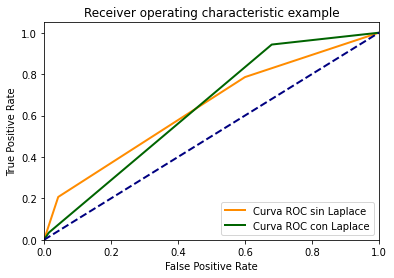

In [28]:
plt.figure()
lw = 2
plt.plot([0, german_fpr, tic_fpr,  1], [0, german_tpr, tic_tpr,  1], color='darkorange',
         lw=lw, label='Curva ROC sin Laplace')
plt.plot([0, german_fprl, tic_fprl,  1], [0, german_tprl, tic_tprl,  1], color='darkgreen',
         lw=lw, label='Curva ROC con Laplace')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Observamos como esperabamos que la corrección de Laplace mejora el resultado en tictac pero lo empeora en german. Tambien podemos observar que nyestro clasificador hace una clasificación buena pues en ambos casos (con y sin Laplace) la curva ROC queda significativamente por encima de la recta que representa la clasificación aleatoria.